In [ ]:
############
# Imports #

import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from torchvision import models, transforms
from utils import ImageDataset, SaveFeatures, accuracy, imshow_transform
from VGG_16bn_gradCAM import vgg16bn_fc
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from skimage.transform import resize
from skimage.io import imshow
import wandb
import matplotlib.pyplot as plt 

%matplotlib inline


###################
# Hyperparameters #

n_samples = 100
n_samples_train = int(round(n_samples*0.8))
batch_size = 5
current_computer = "macbook" # "ubuntu"
layers_to_freeze = 39
lr = 0.0001
weight_decay=0.05
num_epochs = 15
im_size = 100


##########################
# log hyperparams to w&b #

# run = wandb.init(
#     # Set the project where this run will be logged
#     project="VGG_CAMs",
#     # Track hyperparameters and run metadata
#     config={
#         "learning_rate": lr,
#         "epochs": num_epochs,
#         "batch_size": batch_size,
#         "n_samples": n_samples,
#         "layers_to_freeze": layers_to_freeze,
#         "weight_decay": weight_decay,
#         "im_size": im_size
#     },
#     tags = ["BCELoss", "FullyConnectedClassifier", "gradCAM", "StillGenerateCAMs", "LRscheduler"]
# )

#############
# Load data #

if current_computer == "ubuntu":
    image_dir = f"/home/nadjaflechner/Palsa_data/dataset_{im_size}m/"
    labels_file = f"/home/nadjaflechner/Palsa_data/binary_palsa_labels_{im_size}m.csv"
elif current_computer == "macbook":
    image_dir = f"/Users/nadja/Documents/UU/Thesis/Data/{im_size}m"
    labels_file = f"/Users/nadja/Documents/UU/Thesis/Data/{im_size}m_palsa_labels.csv"

# Load the labels from the CSV file
labels_df = pd.read_csv(labels_file, index_col=0).head(n_samples)

# Split the dataset into training and validation sets
train_df = labels_df.head(n_samples_train)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(image_dir, train_df )
val_dataset = ImageDataset(image_dir, val_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [20]:
from VGG_16bn_gradCAM import vgg16bn_fc

################
# Define model #save/to/path/model

model = vgg16bn_fc()

#freeze layers
for idx, param in enumerate(model.parameters()):
    if idx == layers_to_freeze:
        break
    param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.92)
loss_function = nn.BCELoss()

In [ ]:
##################
# Training loop #

# adapted from https://github.com/tony-mtz/CAM/blob/master/network/net.py

weights = models.VGG16_BN_Weights.DEFAULT
transforms = weights.transforms()

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []

max_val_acc = 0

for epoch in range(num_epochs):
    print('EPOCH: ',epoch+1)

    train_acc = []
    val_acc = []

    running_loss = 0.0
    model.train()
    train_batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_loader):     

        # load images and labels 
        images = Variable(transforms(images)).to(device)
        labels = Variable(labels.float()).to(device)

        # train batch   
        outputs = model(images)   
        optimizer.zero_grad()
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        train_acc.append(accuracy(outputs.squeeze(), labels.float()))
        running_loss += loss.item()
        train_batch_count += 1
   
    model.eval()
    val_batch_count = 0
    val_running_loss = 0.0
    model.to(device)

    for batch_idx, (images, labels) in enumerate(val_loader):     
        # inference   
        images = Variable(transforms(images)).to(device)
        labels = Variable(labels.float()).to(device)
        outputs = model(images)

        loss = loss_function(outputs, labels.unsqueeze(1))

        val_acc.append(accuracy(outputs.squeeze(), labels.float()))
        val_running_loss += loss.item()
        val_batch_count +=1

    scheduler.step()

    # update losses and accuracies 

    mean_train_acc.append(np.mean(train_acc))
    mean_val_acc.append(np.mean(val_acc))
    mean_train_losses.append(running_loss/train_batch_count)
    mean_val_losses.append(val_running_loss/val_batch_count)

    wandb.log({"train_accuracy": np.mean(train_acc)})
    wandb.log({"val_accuracy": np.mean(val_acc)})
    wandb.log({"train_loss": running_loss/train_batch_count})
    wandb.log({"val_loss": val_running_loss/val_batch_count})

    if np.mean(val_acc) > max_val_acc:
        best_model = model.state_dict()
        max_val_acc = np.mean(val_acc)

torch.save(best_model, '/home/nadjaflechner/models/model.pth')
artifact = wandb.Artifact('model', type='model')
artifact.add_file('/home/nadjaflechner/models/model.pth')
run.log_artifact(artifact)


In [ ]:
##########################
# plot loss and accuracy #

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax1.plot([i for i in range(num_epochs)], mean_val_losses, c = 'b', label = 'val loss')
ax1.plot([i for i in range(num_epochs)], mean_train_losses, c = 'r', label = 'train loss')
ax1.set_xlabel("Epochs")
ax1.set_xticks(range(0,num_epochs+1,5))
ax1.legend()

ax2.plot([i for i in range(num_epochs)], mean_val_acc, c = 'b', label = 'val accuracy')
ax2.plot([i for i in range(num_epochs)], mean_train_acc, c = 'r', label = 'train accuracy')
ax2.set_xlabel("Epochs")
ax2.set_xticks(range(0,num_epochs+1,5))
ax2.legend()

plt.tight_layout()
plt.show()

wandb.log({'model_performance': wandb.Image(fig)})

In [ ]:
wandb.finish()

### Trying visualization of models (from wandb state dicts)

In [26]:
# run = wandb.init(project= 'VGG_CAMs', id= 'ke9zuztx', resume = 'must')
# artifact = run.use_artifact('nadjaflechner/VGG_CAMs/model:v21', type='model')
# artifact_dir = artifact.download()
# # state_dict = torch.load(f"{artifact_dir}/model.pth")
# state_dict = torch.load(f"{artifact_dir}/model.pth", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [29]:
# defines two global scope variables to store our gradients and activations

# ALL THE BELOW IS BASED OFF OF https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569

gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

backward_hook = model.features.register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model.features.register_forward_hook(forward_hook, prepend=False)

In [39]:
#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

im, lab = next(iter(valid_loader))

if lab == 1:
    print('yes')
    weights = models.VGG16_BN_Weights.DEFAULT
    transforms = weights.transforms()

    im = Variable(im)#.to(device)
    outputs = model(transforms(im))
    outputs.backward()

# loss = loss_function(outputs, lab.unsqueeze(1))
# loss.backward()

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


yes


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Forward hook running...
Activations size: torch.Size([1, 1, 14, 14])
Backward hook running...
Gradients size: torch.Size([1, 1, 14, 14])


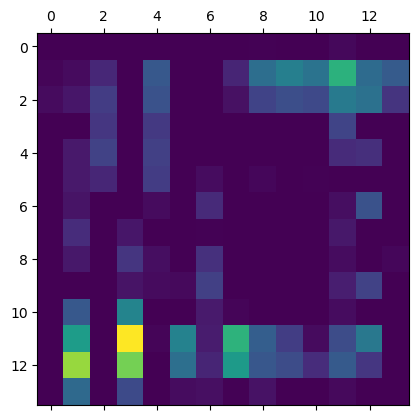

In [40]:
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

import torch.nn.functional as F
import matplotlib.pyplot as plt

# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach())

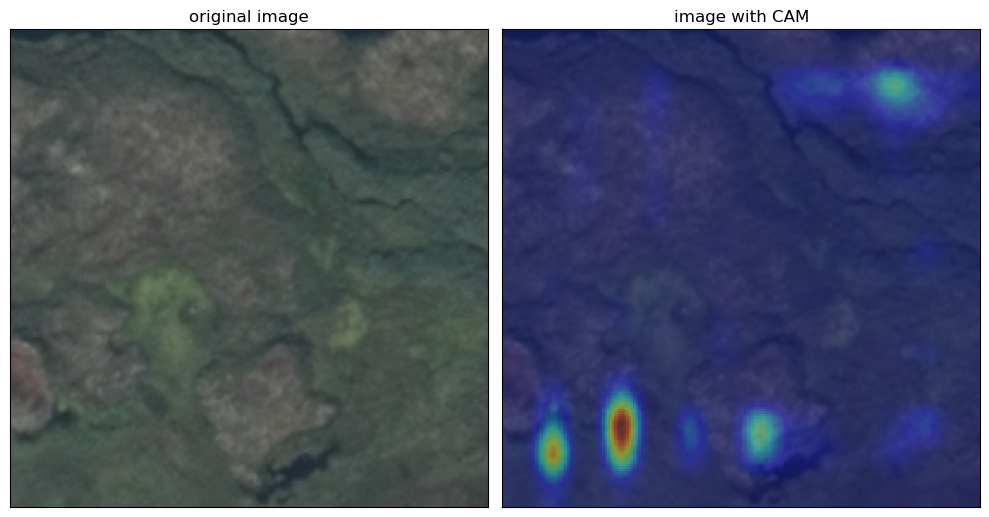

In [41]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

# Plot image with CAM
cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))

ax1.imshow(cpu_img)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('original image')

ax2.imshow(cpu_img)

overlay = to_pil_image(heatmap.detach(), mode='F').resize((200,200), resample=PIL.Image.BICUBIC)

# Apply any colormap you want
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes, 
# but with alpha < 1 (this defines the transparency of the heatmap)
ax2.imshow(overlay, alpha=0.4, interpolation='nearest') #, extent=extent)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('image with CAM')

plt.tight_layout()

In [ ]:
from VGG_16bn_gradCAM import vgg16bn_fc

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

# Load best model to produce CAMs with
model.load_state_dict(best_model)
model.eval()

# Save 10 palsa images

im, lab = next(iter(valid_loader))

im = Variable(im).to(device)
outputs = model(transforms(im)).to(device)
outputs.backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(transforms(im)).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

# CAM = resize(heatmap, (im_size*2,im_size*2))


# cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

# fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))

# ax1.imshow(cpu_img)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_title('original image')

# ax2.imshow(cpu_img)
# ax2.imshow(CAM, alpha=.4, cmap='jet')
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_title('image with CAM')

# plt.tight_layout()

In [ ]:
####################
# generating CAMs #

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

# Load best model to produce CAMs with
model.load_state_dict(best_model)
model.eval()

# Save 10 palsa images
palsa_imgs = 0
for palsa_cam in range(100):
    im, lab = next(iter(valid_loader))

    #get the last convolution
    model.eval()

    if lab == 1:
        palsa_imgs+= 1
        im = Variable(im).to(device)
        outputs = model(transforms(im)).to(device)
        outputs.backward()
        res = torch.argmax(outputs.data).cpu().detach().numpy()

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach().numpy()
        arr1 = arr[0]
        ans_nopalsa = np.dot(np.rollaxis(arr1,0,3), [1,0])
        ans_palsa = np.dot(np.rollaxis(arr1,0,3), [0,1])

        if res==1:
            CAM = resize(ans_palsa, (im_size*2,im_size*2))
        else:
            CAM = resize(ans_nopalsa, (im_size*2,im_size*2))

        # Plot image with CAM
        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))

        ax1.imshow(cpu_img)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title('original image')

        ax2.imshow(cpu_img)
        ax2.imshow(CAM, alpha=.4, cmap='jet')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('image with CAM')

        plt.tight_layout()
        # plt.show()

        # wandb.log({'generated_CAM': fig})

    if palsa_imgs == 10:
        break


In [ ]:
wandb.finish()

In [ ]:
# to load model again: 

run = wandb.init()
artifact = run.use_artifact('nadjaflechner/VGG_CAMs/model:v0', type='model')
artifact_dir = artifact.download()